In [33]:
import tensorflow as tf
import numpy as np
import pandas as pd

from model.backbone import *
from model.positional_encoding import *
from model.transformer import *
from dataset.preparator import prepare
import matplotlib.pyplot as plt

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
ticker = 'MSFT'
seq_len = 10

path = prefix = 'macro'

df_train = pd.read_csv(f'data/processed/{path}/{ticker}_{prefix}_train.csv', index_col=0)
df_val = pd.read_csv(f'data/processed/{path}/{ticker}_{prefix}_val.csv', index_col=0)
df_test = pd.read_csv(f'data/processed/{path}/{ticker}_{prefix}_test.csv', index_col=0)
X_train, y_train, X_val, y_val, X_test, y_test = prepare(ticker,path,prefix, 10, pca='all', task='reg')

MSFT
['macro_pca*_0', 'macro_pca*_1', 'macro_pca*_2', 'macro_pca*_3', 'macro_pca*_4', 'macro_pca*_5', 'macro_pca*_6', 'macro_pca*_7', 'macro_pca_8', 'tech_pca*_0', 'tech_pca*_1', 'tech_pca*_2', 'tech_pca_3', 'tech_pca_4']
Training set shape (3344, 10, 14) (3344,)
Validation set shape (410, 10, 14) (410,)
Testing set shape (410, 10, 14) (410,)


In [36]:
instance = f'{ticker}_{prefix}_reg10_4_pca_all_huber0.1'

In [37]:

model = tf.keras.models.load_model(f'instances/{instance}.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder,
                                                   'LinearBackbone': LinearBackbone,
                                                   'ConvBackbone': ConvBackbone})

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))


13/13 [==============================] - 1s 89ms/step - loss: 0.0402 - mae: 0.4491 - mape: 306.4658
 
Evaluation metrics
Training Data - Loss: 0.0333, MAE: 0.3798, MAPE: 132325.4844
Validation Data - Loss: 0.0338, MAE: 0.3846, MAPE: 303.0388
Test Data - Loss: 0.0402, MAE: 0.4491, MAPE: 306.4658


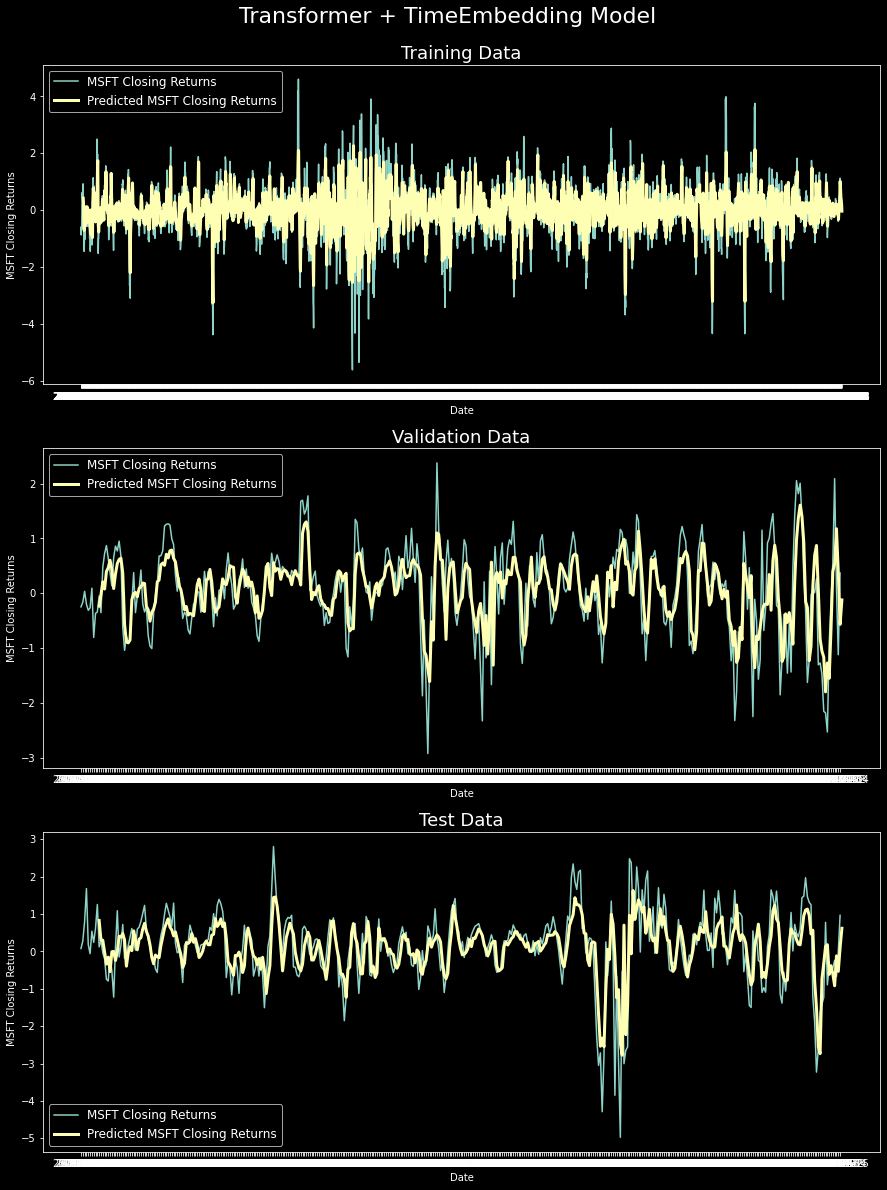

In [38]:

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(df_train.loc[:, 'close'], label=f'{ticker} Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label=f'Predicted {ticker} Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel(f'{ticker} Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(df_val.loc[:, 'close'], label=f'{ticker} Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label=f'Predicted {ticker} Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel(f'{ticker} Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(df_test.loc[:, 'close'], label=f'{ticker} Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label=f'Predicted {ticker} Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel(f'{ticker} Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [161]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


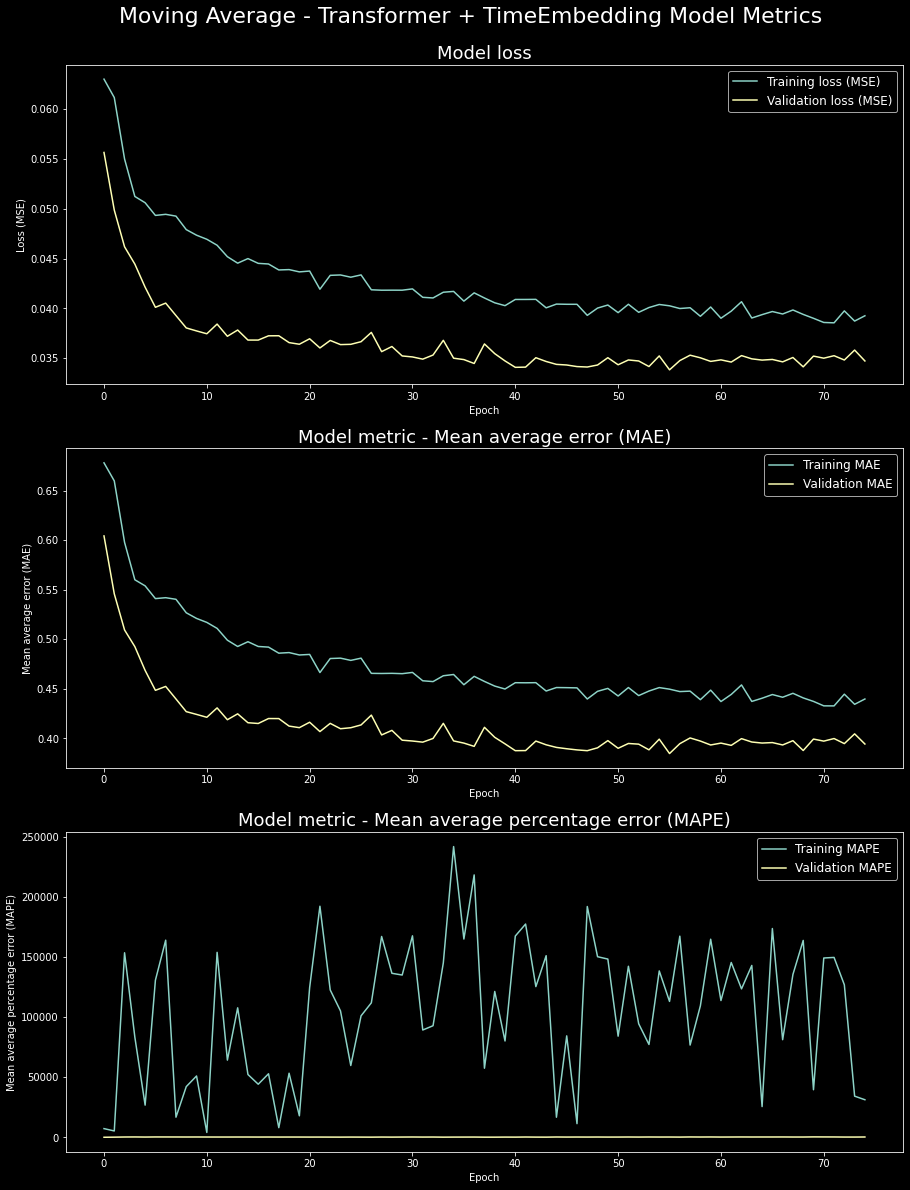

In [39]:
'''Display model metrics'''
import pickle
with open(f'instances/{instance}_history.pickle','rb') as f: history = pickle.load(f)

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history['loss'], label='Training loss (MSE)')
ax1.plot(history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history['mae'], label='Training MAE')
ax2.plot(history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history['mape'], label='Training MAPE')
ax3.plot(history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

In [40]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def classifier_stats(Y, O):
  f1 = f1_score(Y, O)  

  cm = confusion_matrix(Y, O)
  tn, fp, fn, tp = cm.ravel()

  fpr = fp/(fp+tn)
  specificity = 1 - fpr

  fnr = fn/(fn+tp)
  recall = 1 - fnr

  pos_precision = tp/(tp+fp)
  neg_precision = tn/(tn+fn)

  print(f"{fpr = :.4f}, {specificity = :.4f}")
  print(f"{fnr = :.4f}, {recall = :.4f}")
  print(f"{pos_precision = :.4f}, {neg_precision = :.4f}")
  print(f"{f1 = }")

  cm_plot = sns.heatmap(cm, annot=True, fmt='.0f', cmap=sns.color_palette("light:#5A9", as_cmap=True))
  cm_plot.set(xlabel='Predicted', ylabel='True')
  plt.show()

In [41]:
from tabulate import tabulate
import plotly.graph_objects as go

# class evaluation:
#   def find_mdd(self, df):
#     window = 252
#     Roll_Max = self.balance.rolling(window, min_periods=1).max()
#     Daily_Drawdown = self.balance/Roll_Max - 1.0
#     Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()
#     return Max_Daily_Drawdown.min()

#   # def __init__(self, df = None, name = None, static = False):
#   #   if not static:
#   #     self.initial_balance = 10000
#   #     self.name = name
#   #     self.no_trades = df.shape[0]
#   #     self.ret = df['return']
#   #     self.balance = np.cumprod(df['return']+1) * self.initial_balance
#   #     self.cum_ret = (self.balance.iloc[-1]/self.balance.iloc[0]) - 1 
#   #     self.win = df[df['return'] > 0]['return']
#   #     self.lose = df[df['return'] < 0]['return']
#   #     self.avg_win = self.win.mean()
#   #     self.avg_lose = self.lose.mean()
#   #     self.win_rate = self.win.shape[0] / (self.win.shape[0] + self.lose.shape[0])
#   #     self.max_ret = (self.balance.max() / self.balance.iloc[0]) - 1
#   #     self.days_trades = df.index[-1] - df.index[0]
#   #     self.cagr = np.power(self.balance.iloc[-1]/self.balance.iloc[0], 1/(self.days_trades.days/365)) - 1
#   #     self.sharpe = (self.cum_ret)/df['return'].std()
#   #     self.mdd = self.find_mdd(df)
#   #     self.date = df.index
#   #     self.dic = dict()


#   def __init__(self, df = None, name = None, static = False, commission = False):
#     if not static:
#       self.initial_balance = 10000
#       self.name = name
#       self.no_trades = df.shape[0]
#       self.ret = df['return']
#       self.balance = np.cumprod(df['return']+1) * self.initial_balance
#       self.price = df['!close']
#       if commission: 
#         self.apply_commission()
#       self.cum_ret = (self.balance.iloc[-1]/self.balance.iloc[0]) - 1 
#       self.win = df[df['return'] > 0]['return']
#       self.lose = df[df['return'] < 0]['return']
#       self.avg_win = self.win.mean()
#       self.avg_lose = self.lose.mean()
#       self.win_rate = self.win.shape[0] / (self.win.shape[0] + self.lose.shape[0])
#       self.max_ret = (self.balance.max() / self.balance.iloc[0]) - 1
#       self.days_trades = df.index[-1] - df.index[0]
#       self.cagr = np.power(self.balance.iloc[-1]/self.balance.iloc[0], 1/(self.days_trades.days/365)) - 1
#       self.sharpe = (self.cum_ret)/df['return'].std()
#       self.mdd = self.find_mdd(df)
#       self.date = df.index
#       self.price = df['!close']
#       self.dic = dict()

#   def apply_commission(self):
#     for i in range(len(self.balance)):
#       if i == 0:
#         balance = self.initial_balance
#       else:
#         balance = self.balance.iloc[i-1]
#       commission = 1 if 0.005*(balance//self.price.iloc[i]) < 1 else 0.005*(balance//self.price.iloc[i])
#       commission = min(commission, 0.01*balance)
#       #min(max(1, 0.005*(portfolio_value/price)), 0.01*portfolio_value)
#       self.balance.iloc[i] = (balance - commission) * (1+self.ret.iloc[i]) - commission
  
#   def get_dict(self):
#     self.dic = {
#         'name': self.name,
#         'no_trades' : self.no_trades,
#         'cum_ret' : "{0:.3f}%".format(self.cum_ret * 100),
#         'win_rate' : "{0:.3f}%".format(self.win_rate * 100),
#         'Avg. Win' : "{0:.3f}%".format(self.avg_win * 100),
#         'Avg. Lose' : "{0:.3f}%".format(self.avg_lose * 100),
#         'Max Return': "{0:.3f}%".format(self.max_ret * 100),
#         'CAGR': "{0:.3f}%".format(self.cagr * 100),
#         'Sharpe Ratio': "{0:.3f}".format(self.sharpe),
#         'MDD': "{0:.3f}%".format(self.mdd * 100),
#         'trade_turnover': "{0:.3f}".format(self.days_trades.days/self.no_trades)
#     }
#     return self.dic
  
#   def tabulate(self, list_eval):
#     list_dic = []
#     for eval in list_eval:
#       list_dic.append(eval.get_dict())
#     compiled = dict()
#     for key in list_dic[0].keys():
#       compiled[key] = dict()
#       for dic in list_dic:
#           compiled[key][dic['name']] = dic[key]
#     df_compiled = pd.DataFrame(compiled)
#     names = []
#     for dic in list_dic:
#       names.append(dic['name'])
#     print(tabulate(df_compiled.T, headers=names))
  
#   def get_chart(self, list_eval):
#     fig = go.Figure()
#     for eval in list_eval:
#       fig.add_trace(go.Scatter(x=eval.date, y=eval.balance,
#                                mode='lines',
#                                name=eval.name))
#       fig.update_layout(
#           width = 1000,
#           title=f'{ticker.upper()} trading balance'
#       )
#     fig.show()

In [42]:
class evaluation:
  def find_mdd(self, df):
    window = 252
    Roll_Max = self.balance.rolling(window, min_periods=1).max()
    Daily_Drawdown = self.balance/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()
    return Max_Daily_Drawdown.min()
  

  def __init__(self, df = None, name = None, static = False, commission = False):
    if not static:
      self.initial_balance = 10000
      self.name = name
      self.no_trades = df.shape[0]
      self.ret = df['return']
      self.balance = np.cumprod(df['return']+1) * self.initial_balance
      self.price = df['!close']
      if commission: 
        self.apply_commission()
      self.ret = self.balance.pct_change()
      self.ret.iloc[0] = (self.balance.iloc[0] - self.initial_balance)/self.initial_balance

      self.cum_ret = (self.balance.iloc[-1]/self.balance.iloc[0]) - 1 
      self.win = self.ret[self.ret > 0]
      self.lose = self.ret[self.ret < 0]
      self.avg_win = self.win.mean()
      self.avg_lose = self.lose.mean()
      self.win_rate = self.win.shape[0] / (self.win.shape[0] + self.lose.shape[0])
      self.max_ret = (self.balance.max() / self.balance.iloc[0]) - 1
      self.days_trades = df.index[-1] - df.index[0]
      self.cagr = np.power(self.balance.iloc[-1]/self.balance.iloc[0], 1/(self.days_trades.days/365)) - 1
      self.sharpe = (self.cum_ret)/self.ret.std()
      self.mdd = self.find_mdd(df)
      self.date = df.index
      self.price = df['!close']
      self.dic = dict()
      
      

  def apply_commission(self):
    for i in range(len(self.balance)):
      if i == 0:
        balance = self.initial_balance
      else:
        balance = self.balance.iloc[i-1]
      commission = 1 if 0.005*(balance/self.price.iloc[i]) < 1 else 0.005*(balance/self.price.iloc[i])
      commission = min(commission, 0.01*balance)
      #min(max(1, 0.005*(portfolio_value/price)), 0.01*portfolio_value)
      self.balance.iloc[i] = (balance - commission) * (1+self.ret.iloc[i]) - commission
  
  def get_dict(self):
    self.dic = {
        'name': self.name,
        'no_trades' : self.no_trades,
        'cum_ret' : "{0:.6f}%".format(self.cum_ret * 100),
        'win_rate' : "{0:.6f}%".format(self.win_rate * 100),
        'Avg. Win' : "{0:.6f}%".format(self.avg_win * 100),
        'Avg. Lose' : "{0:.6f}%".format(self.avg_lose * 100),
        'Max Return': "{0:.6f}%".format(self.max_ret * 100),
        'CAGR': "{0:.6f}%".format(self.cagr * 100),
        'Sharpe Ratio': "{0:.6f}".format(self.sharpe),
        'MDD': "{0:.6f}%".format(self.mdd * 100),
        'trade_turnover': "{0:.6f}".format(self.days_trades.days/self.no_trades)
    }
    return self.dic
  
  def tabulate(self, list_eval):
    list_dic = []
    for eval in list_eval:
      list_dic.append(eval.get_dict())
    compiled = dict()
    for key in list_dic[0].keys():
      compiled[key] = dict()
      for dic in list_dic:
          compiled[key][dic['name']] = dic[key]
    df_compiled = pd.DataFrame(compiled)
    names = []
    for dic in list_dic:
      names.append(dic['name'])
    print(tabulate(df_compiled.T, headers=names))
  
  def get_chart(self, list_eval):
    fig = go.Figure()
    for eval in list_eval:
      fig.add_trace(go.Scatter(x=eval.date, y=eval.balance,
                               mode='lines',
                               name=eval.name))
      fig.update_layout(
          width = 1000,
          title=f'{ticker.upper()} trading balance'
      )
    fig.show()

In [43]:
df_train = df_train.iloc[seq_len-1:,]
df_val = df_val.iloc[seq_len-1:,]
df_test = df_test.iloc[seq_len-1:,]

df_train['pred'] = train_pred
df_val['pred'] = val_pred
df_test['pred'] = test_pred

In [44]:
df_test

,open,high,low,close,volume,^IRX,^TNX,^TYX,CL=F,GC=F,...,macro_pca*_6,macro_pca*_7,macro_pca_8,tech_pca*_0,tech_pca*_1,tech_pca*_2,tech_pca_3,tech_pca_4,Y_reg,pred
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-18,1.109061,1.183013,1.149874,1.255232,0.563220,-0.071804,0.657791,0.594749,0.690285,-0.236947,...,0.010489,0.125250,-0.009132,-2.371921,0.554886,0.091415,-0.032655,-0.061870,0.120888,0.827512
2019-01-22,1.108557,0.508919,0.786638,0.120888,0.058425,-0.121741,0.186403,-0.096670,0.108121,-0.186291,...,0.111123,-0.042617,-0.144062,-1.298592,-0.008913,-0.709289,-0.137665,0.014533,0.294315,0.301866
2019-01-23,0.175396,0.156330,0.046074,0.294315,-0.260147,-0.034133,0.222073,-0.016726,0.057735,-0.301541,...,-0.052304,0.309089,-0.102303,-0.373447,-0.293780,0.093673,0.127865,-0.136511,-0.036211,0.298604
2019-01-24,0.446208,0.043516,0.101957,-0.036211,-0.372461,-0.161540,-0.227537,-0.336444,0.307215,-0.383784,...,-0.391291,0.395655,-0.027216,-0.318184,-0.428435,-0.335632,0.053516,-0.130619,-0.197974,-0.023664
2019-01-25,-0.116810,-0.063347,0.020312,-0.197974,-0.331110,-0.066090,-0.180183,-0.262963,-0.081291,0.290486,...,0.436084,0.115873,-0.036017,0.133168,-0.397802,-0.049035,-0.006685,0.138701,-0.747792,-0.339497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,-1.061601,-0.977534,-1.174165,-0.450745,0.547311,-1.621611,0.045429,0.398895,0.895100,-0.929545,...,-1.171076,0.097024,0.202859,1.813008,0.470096,0.430080,0.024744,-0.291431,-0.240186,-0.920262
2020-09-22,-0.523249,-0.293102,-0.752370,-0.240186,0.872967,-0.938958,-0.404168,-0.288984,0.548694,-1.022173,...,-1.000711,0.178756,0.098540,0.892198,0.837733,0.205078,0.175992,-0.118169,-0.671718,-0.118780
2020-09-23,-0.430227,-0.414006,-0.725218,-0.671718,0.317977,-0.938958,-0.279630,-0.361283,-0.145820,-1.716452,...,-1.233138,-0.219153,-0.008258,1.094361,0.264901,-0.158196,0.172247,0.013184,-0.018694,-0.535368


fpr = 0.3626, specificity = 0.6374
fnr = 0.5983, recall = 0.4017
pos_precision = 0.6076, neg_precision = 0.4325
f1 = 0.4836272040302267


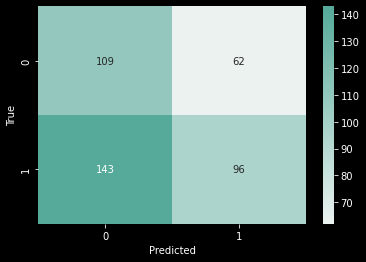

In [45]:
avg = 5

O = (df_test['pred'] > df_test['close']) & df_test['!close_pct'].shift(avg-1) > 0
Y = df_test['!close_pct'].shift(-1) > 0
classifier_stats(Y,O)

In [46]:
df_trade = df_test
df_trade.index = pd.to_datetime(df_trade.index)
df_trade['close_pct_tmr'] = df_trade['!close_pct'].shift(-1)
df_trade['open_tmr'] = df_trade['!open'].shift(-1)
df_trade = df_trade.iloc[:-1,:]

In [47]:
def process_condition(long_cond = None, short_cond = None, risk = None, buy_hold = False, comission=None, sl_cond=True, rf=None, open=False):
  open_sl_count = 0
  open_sl = False
  if not buy_hold:
    if rf != None:
      risk_free = rf
    else:
      risk_free = 0
    leverage = 1
    trades = df_trade[long_cond | short_cond]
    if open:
      trades['down_tmr'] = (trades['!low'].shift(-1) - trades['open_tmr'])/trades['open_tmr']
      trades['up_tmr'] = (trades['open_tmr'] - trades['open_tmr'])/trades['open_tmr']
    else:
      trades['down_tmr'] = (trades['!low'].shift(-1) - trades['!close'])/trades['!close']
      trades['up_tmr'] = (trades['!close'] - trades['!high'].shift(-1))/trades['!close']
      trades['open_close_tmr'] = (trades['open_tmr'] - trades['!close'])/trades['!close']
    long = 0
    short = 0
    no_trade = 0
    trades['return'] = 0
    trades.dropna(inplace=True)
    stop_loss = risk
    for i in range(trades.shape[0]): 
      stop_col = 'down_tmr' if trades.loc[trades.index[i], 'pred'] - trades.loc[trades.index[i], 'close']> 0 else 'up_tmr'
      if sl_cond:
        if trades.loc[trades.index[i], stop_col] > stop_loss:  
          if stop_col == 'down_tmr':
            if comission != None:
              ret = ((1 + trades.loc[trades.index[i], 'close_pct_tmr']) * np.power((1-comission),2)) - 1
            else:  
              ret = (trades.loc[trades.index[i], 'close_pct_tmr'])
            trades.loc[trades.index[i], 'return'] = ret if ret > stop_loss else stop_loss
            long += 1
          if stop_col == 'up_tmr':
            if comission != None:
              ret = risk_free + leverage * (risk_free + ((1 + -1*(trades.loc[trades.index[i], 'close_pct_tmr'])) * np.power((1-comission),2)) - 1)
            else:
              ret = risk_free + leverage * (risk_free + -1*(trades.loc[trades.index[i], 'close_pct_tmr']))
            trades.loc[trades.index[i], 'return'] = ret if ret > stop_loss else stop_loss
            short += 1
        else: 
          ret = min(stop_loss, trades.loc[trades.index[i], 'open_close_tmr']*(1 if stop_col=='down_tmr' else -1))
          if comission != None:
            ret = ((1+ret)* np.power((1-comission),2)) - 1
          # else:
          #   ret = stop_loss
          trades.loc[trades.index[i], 'return'] = ret #if ret > stop_loss else stop_loss
      else: #no_stop_loss
        if stop_col == 'down_tmr':
          if comission != None:
            trades.loc[trades.index[i], 'return'] = ((1 + trades.loc[trades.index[i], 'close_pct_tmr']) * np.power((1-comission),2)) - 1
          else:  
            trades.loc[trades.index[i], 'return'] = (trades.loc[trades.index[i], 'close_pct_tmr'])
          long += 1
        if stop_col == 'up_tmr':
          if comission != None:
            trades.loc[trades.index[i], 'return'] = risk_free + leverage * (risk_free + ((1 + -1*(trades.loc[trades.index[i], 'close_pct_tmr'])) * np.power((1-comission),2)) - 1)
          else:
            trades.loc[trades.index[i], 'return'] = risk_free + leverage * (risk_free + -1*(trades.loc[trades.index[i], 'close_pct_tmr']))
          short += 1
    
    # if sl_cond:
    #   if comission:
    #     trades.loc[trades['return'] < ((1+stop_loss)* np.power((1-comission),2)) - 1, 'return'] = ((1+stop_loss)* np.power((1-comission),2)) - 1
    #   else:
    #     trades.loc[trades['return'] < stop_loss, 'return'] = stop_loss
    
  else: # Buy and hold
    trades = df_trade
    trades['return'] = trades['close_pct_tmr']
  trades['date'] = trades.index
  return trades

In [48]:
# With short and long and checking
list_eval = []
# risk = -0.001
comission = 0
long_cond = (df_trade['pred'] - df_trade['close'] > 0) & (df_trade['!close_pct'].shift(avg-1) > 0)
short_cond = (df_trade['pred'] - df_trade['close'] < 0) & (df_trade['!close_pct'].shift(avg-1) < 0)

risk = -0.1
cum_ret = 0
opt_risk = 0
while risk < -0.0000000001:
  original_stoploss = process_condition(long_cond, short_cond, risk)
  original_stoploss_eval = evaluation(original_stoploss, 'original_stoploss')
  print(f'risk: {risk}, cum_ret = {original_stoploss_eval.cum_ret}')
  if original_stoploss_eval.cum_ret > cum_ret:
    cum_ret = original_stoploss_eval.cum_ret
    opt_risk = risk
  risk /= 10
print(f"optimal cum_ret: {cum_ret}, optimal risk: {opt_risk}")


# original = process_condition(long_cond, short_cond, sl_cond=False)
# original_eval = evaluation(original, 'original')
# list_eval.append(original_eval)

original_comission = process_condition(long_cond, short_cond, risk, sl_cond=False, comission=0)
original_comission_eval = evaluation(original_comission, 'without stoploss', commission=True)
list_eval.append(original_comission_eval)

# original_stoploss = process_condition(long_cond, short_cond, risk=opt_risk)
# original_stoploss_eval = evaluation(original_stoploss, 'original_stoploss')
# list_eval.append(original_stoploss_eval)

original_stoploss_comission = process_condition(long_cond, short_cond, risk=opt_risk, comission=0)
original_stoploss_comission_eval = evaluation(original_stoploss_comission, 'with stoploss', commission=True)
list_eval.append(original_stoploss_comission_eval)

buy_hold = process_condition(buy_hold=True)
buy_hold_eval = evaluation(buy_hold, 'buy and hold')
list_eval.append(buy_hold_eval)

evaluation(static=True).tabulate(list_eval)
evaluation(static=True).get_chart(list_eval)

risk: -0.1, cum_ret = 0.051542423079914856
risk: -0.01, cum_ret = -0.15238121084409229
risk: -0.001, cum_ret = 0.06135794667845551
risk: -0.0001, cum_ret = 0.0965717267554358
risk: -1e-05, cum_ret = 0.10112119482857085
risk: -1.0000000000000002e-06, cum_ret = 0.10157715588844196
risk: -1.0000000000000002e-07, cum_ret = 0.10162276215182486
risk: -1.0000000000000002e-08, cum_ret = 0.10162732287974863
risk: -1.0000000000000003e-09, cum_ret = 0.10162777895356001
risk: -1.0000000000000003e-10, cum_ret = 0.10162782456094854
optimal cum_ret: 0.10162782456094854, optimal risk: -1.0000000000000003e-10
                without stoploss    with stoploss    buy and hold
--------------  ------------------  ---------------  --------------
name            without stoploss    with stoploss    buy and hold
no_trades       124                 124              409
cum_ret         9.369562%           7.646521%        87.658787%
win_rate        52.419355%          26.612903%       58.722359%
Avg. Win       

In [114]:
# With short and long and checking
list_eval = []
risk = -0.0001
comission = 0
long_cond = (df_trade['pred'] - df_trade['close'] > 0) & (df_trade['!close_pct'].shift(avg-1) > 0)
short_cond = (df_trade['pred'] - df_trade['close'] < 0) & (df_trade['!close_pct'].shift(avg-1) < 0)

original = process_condition(long_cond, short_cond, risk, sl_cond=False)
original_eval = evaluation(original, 'original')
list_eval.append(original_eval)

original_comission = process_condition(long_cond, short_cond, risk, sl_cond=False, comission=comission)
original_comission_eval = evaluation(original_comission, 'original_comission', commission=True)
list_eval.append(original_comission_eval)

original_stoploss = process_condition(long_cond, short_cond, risk)
original_stoploss_eval = evaluation(original_stoploss, 'original_stoploss')
list_eval.append(original_stoploss_eval)

original_stoploss_comission = process_condition(long_cond, short_cond, risk, comission=comission)
original_stoploss_comission_eval = evaluation(original_stoploss_comission, 'original_stoploss_comission', commission=True)
list_eval.append(original_stoploss_comission_eval)


# long_cond = (df_trade['pred'] - df_trade['close'] > 0 )
# short_cond = (df_trade['pred'] - df_trade['close'] < 0 )

# reckless = process_condition(long_cond, short_cond, risk)
# reckless_eval = evaluation(reckless, 'reckless_stoploss')
# list_eval.append(reckless_eval)

# reckless_comission = process_condition(long_cond, short_cond, risk, comission=comission)
# reckless_comission_eval = evaluation(reckless_comission, 'reckless_stoploss_comission')
# list_eval.append(reckless_comission_eval)


buy_hold = process_condition(buy_hold=True)
buy_hold_eval = evaluation(buy_hold, 'buy_and_hold')
list_eval.append(buy_hold_eval)

evaluation(static=True).tabulate(list_eval)
evaluation(static=True).get_chart(list_eval)

                original     original_comission    original_stoploss    original_stoploss_comission    buy_and_hold
--------------  -----------  --------------------  -------------------  -----------------------------  --------------
name            original     original_comission    original_stoploss    original_stoploss_comission    buy_and_hold
no_trades       177          177                   177                  177                            433
cum_ret         47.616232%   43.315502%            79.175152%           74.514025%                     135.004913%
win_rate        54.802260%   54.802260%            33.898305%           33.898305%                     54.861111%
Avg. Win        1.747972%    1.730995%             2.051847%            2.036443%                      1.705897%
Avg. Lose       -1.563120%   -1.579834%            -0.523518%           -0.538397%                     -1.567745%
Max Return      48.844070%   44.647417%            86.543119%           81.832337%     

# Results

### Robust Scalar Gmean

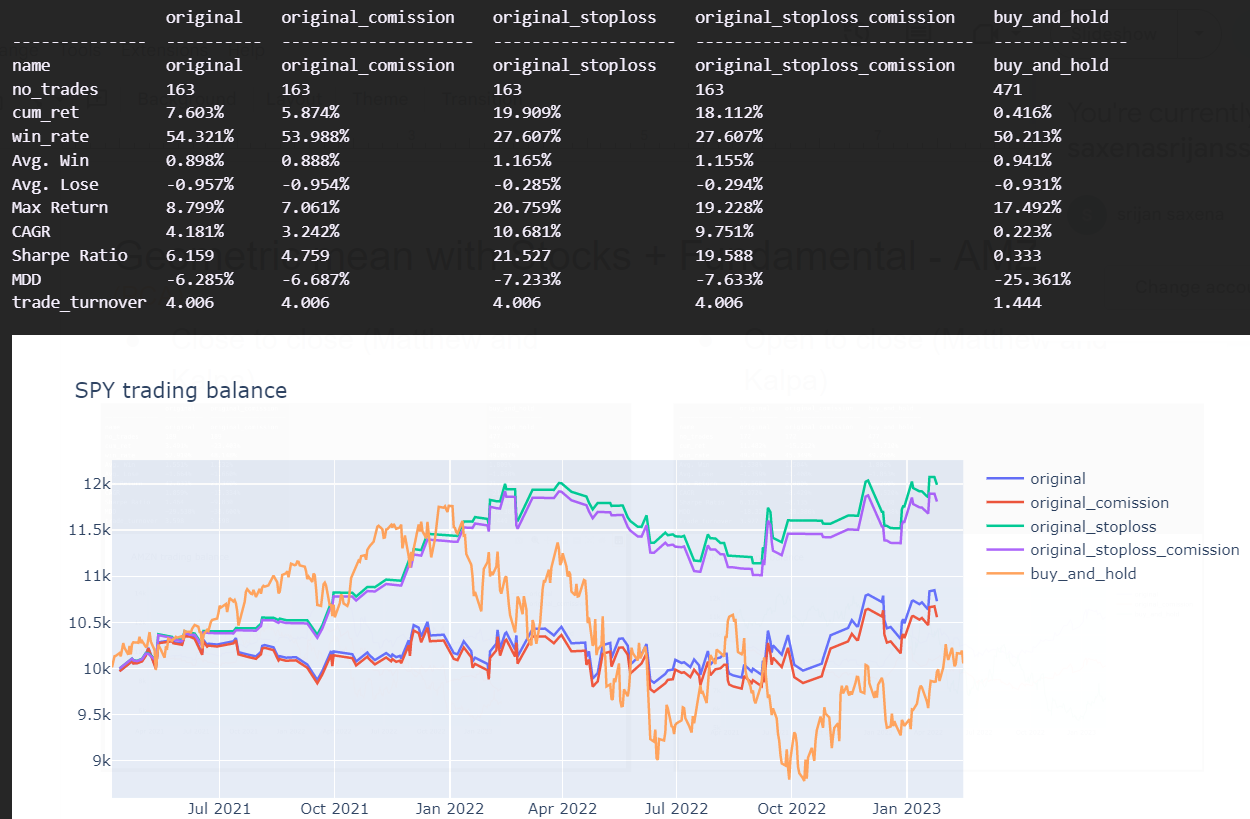

### Macro

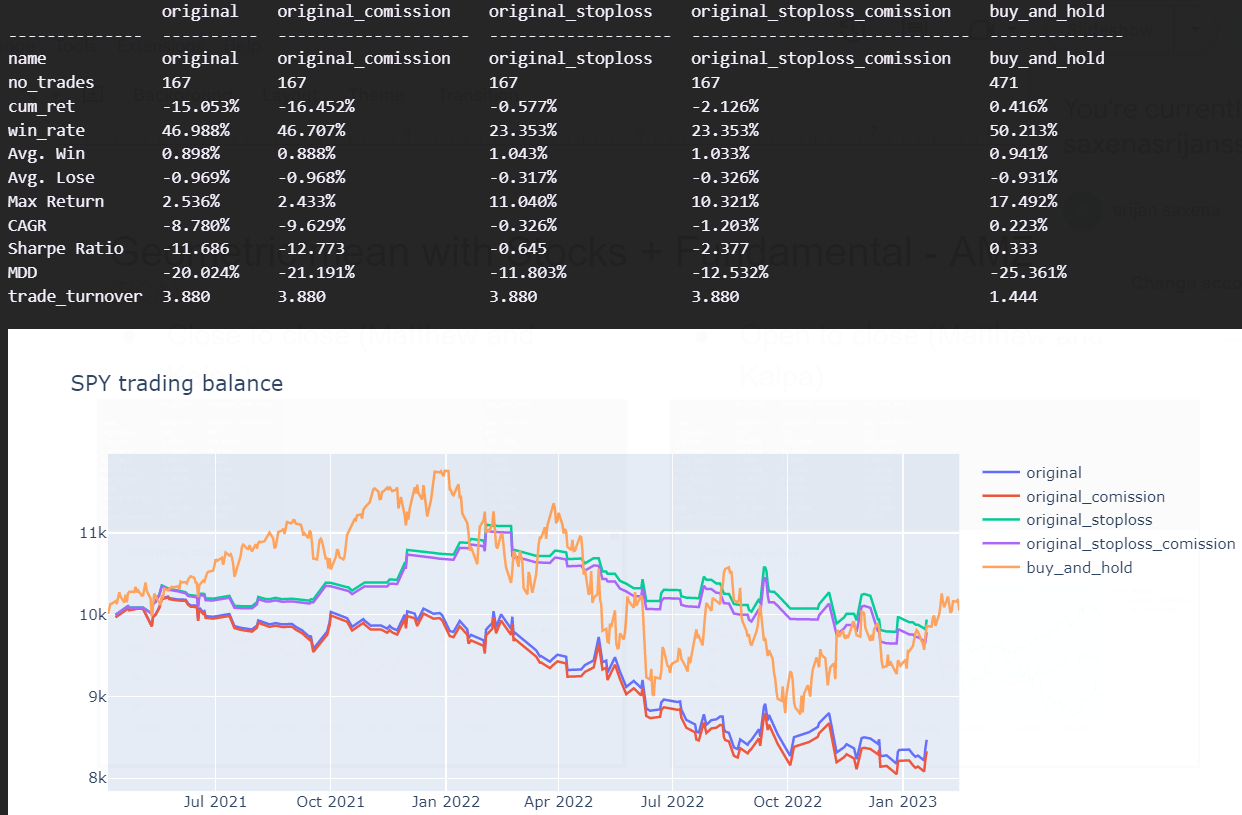

### Macro PCA

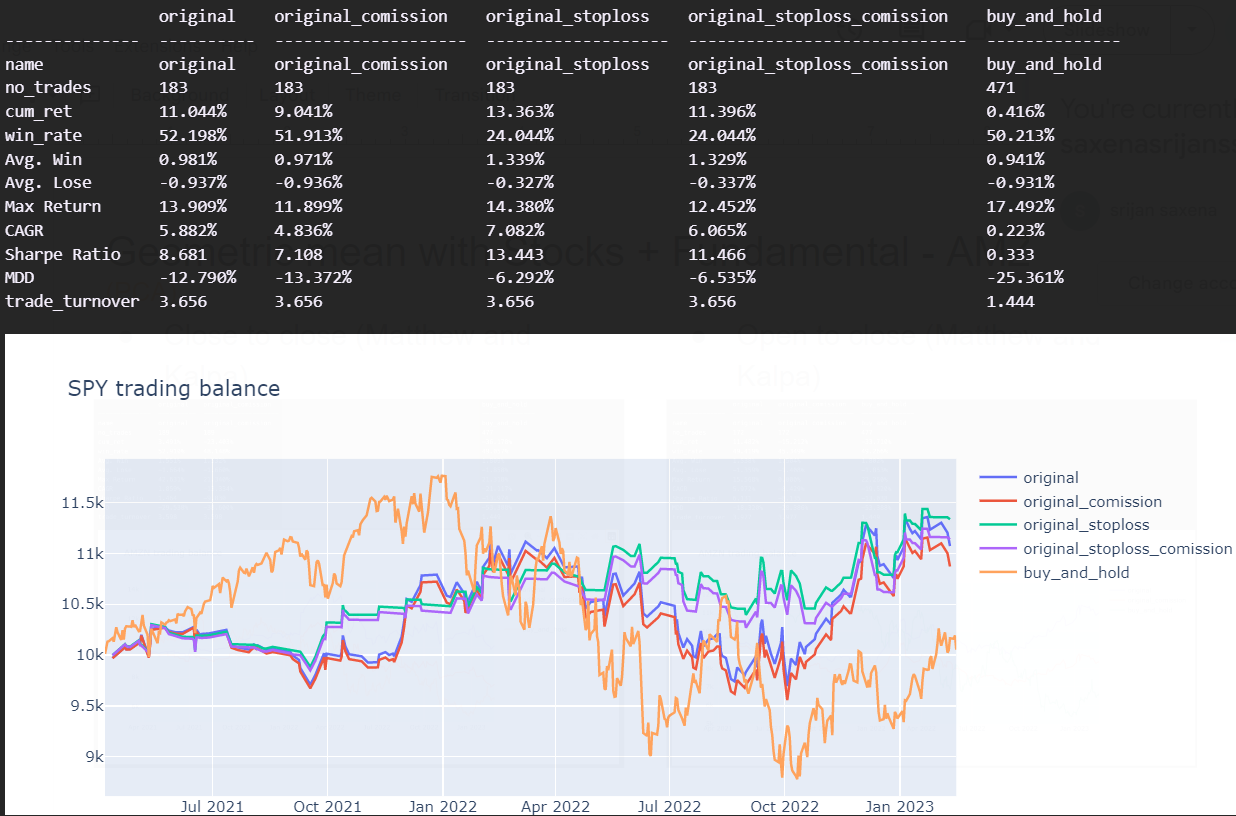